# Genetic Algorithm for Logic Circuit Design

In this notebook, we will explore the **Genetic Algorithm (GA)** and use it to solve a specific problem: **designing an optimized logic circuit**. The Genetic Algorithm is a powerful method inspired by natural selection, capable of finding solutions to complex optimization problems.  

The steps we will cover are:  
1. **Introduction to Genetic Algorithm:**  
   - Understanding the basic concepts and how GA mimics natural evolution.  
   - Exploring its connection to Darwin’s theory of natural selection.  
2. **Defining the Problem:**  
   - Explaining the logic circuit design problem and its requirements.  
3. **Implementing the Genetic Algorithm:**  
   - Creating a population of candidate circuits.  
   - Evaluating their performance.  
   - Using selection, crossover, and mutation to generate better solutions.  
4. **Analyzing Results:**  
   - Examining how the algorithm converges to an optimal or near-optimal logic circuit.  
5. **Conclusion:**  
   - Summarizing the effectiveness of the Genetic Algorithm for this problem.


### Genetic Algorithm and Its Connection to Darwin's Theory  

The **Genetic Algorithm (GA)** is based on **Charles Darwin’s theory of natural selection**, which explains how living things change over time to fit their environment.  

#### Connection to Darwin’s Theory:  
Darwin’s main ideas were:  
1. **Survival of the fittest:** Animals or plants that are better suited to their environment have a better chance to live.  
2. **Reproduction:** These stronger ones pass their good traits to their children.  
3. **Variation:** Small random changes happen in traits, which sometimes help them survive better.  

#### How This Relates to Genetic Algorithms:  
In the 1960s, **John Holland** wanted to copy this natural process to solve problems using computers. His idea was:  
- Think of a group of **possible solutions** as if they were living things.  
- Over time, the better solutions “survive” and mix their traits to create new and improved solutions.  
- Random small changes keep variety in the solutions, which can lead to finding the best one.  

#### Fun Fact:  
Holland didn’t just want to copy nature. He also wanted to use these ideas to solve real problems in math and engineering. His book, published in 1975, was a key step in developing the Genetic Algorithm.  


### Steps of the Genetic Algorithm  

The Genetic Algorithm works in several key steps that progressively improve solutions to find the best one. These steps are generally as follows:

1. **Initialization:**  
   We start by creating an initial population of random solutions. Each solution can be represented as a string of data (like binary) that symbolizes a possible answer to the problem.

2. **Fitness Evaluation:**  
   Each solution is evaluated to see how well it solves the problem. A fitness value is assigned to each solution, indicating how good it is in relation to others.

3. **Selection:**  
   Solutions with higher fitness are more likely to be selected for reproduction. This step is similar to natural selection, where the fittest individuals have a better chance of passing on their traits.

4. **Crossover:**  
   After selecting parents, we combine their traits to create new offspring. This process, called crossover, blends the features of the parents to generate new solutions that might inherit the best traits from each.

5. **Mutation:**  
   Mutation introduces small, random changes to the offspring's traits. This helps maintain diversity and prevents the algorithm from getting stuck in local optima by introducing new possibilities.

6. **Elitism:**  
   The best solutions from each generation are directly passed to the next generation without any changes. This ensures that the best traits are preserved and the algorithm doesn’t lose progress.

7. **Replacement:**  
   The new generation replaces the old one, and the process repeats until an optimal or near-optimal solution is found.


#### 1. Initialization  

In the first step, we create an **initial population** of solutions. This population consists of multiple individuals (solutions), and each individual is represented as a sequence of data. These sequences are called **chromosomes** in the context of the Genetic Algorithm. Chromosomes encode potential solutions to the problem.

##### Example:  
Let’s say we are solving a problem where we need to maximize the sum of bits in a binary string of length 6.  

- Each chromosome is a binary string, such as:  
  `101010`, `111000`, `000111`, `110011`  

- The initial population might have **4 chromosomes**, and each one is randomly generated.  
  For example:  
  ```  
  Population:  
  Chromosome 1: 101010  
  Chromosome 2: 111000  
  Chromosome 3: 000111  
  Chromosome 4: 110011  
  ```  

- At this stage, the chromosomes are just random guesses. Their quality will be evaluated in the next step using a fitness function.

##### Why is Initialization Important?  
The diversity in the initial population ensures that the algorithm explores different areas of the solution space. This is crucial for finding an optimal or near-optimal solution. A poor or overly similar initial population might lead to premature convergence.


#### 2. Fitness Evaluation  

Once the initial population (chromosomes) is created, the next step is to evaluate how good each chromosome is at solving the problem. This is done using a **fitness function**, which assigns a numerical score to each chromosome. The higher the fitness score, the better the chromosome.

##### Example:  
Let’s continue with the example where the goal is to maximize the **sum of bits** in a 6-bit binary string.

- **Fitness Function:** In this case, the fitness function is the sum of the `1`s in the binary string.  

- **Population:**  
  ```  
  Chromosome 1: 101010 → Fitness = 3  
  Chromosome 2: 111000 → Fitness = 3  
  Chromosome 3: 000111 → Fitness = 3  
  Chromosome 4: 110011 → Fitness = 4  
  ```  

Here, chromosome 4 (`110011`) has the highest fitness score of `4`, meaning it is currently the best solution in the population.

##### Why is Fitness Evaluation Important?  
Fitness evaluation guides the algorithm by helping it identify which chromosomes are performing better. In the next steps, chromosomes with higher fitness will have a better chance of being selected for reproduction, ensuring that their good traits are passed on to the next generation.


#### 3. Selection  

After evaluating the fitness of each chromosome, the next step is **selection**, where we choose which chromosomes will be the parents for the next generation. The idea is to give a higher chance of selection to chromosomes with better fitness scores. This mimics natural selection, where stronger individuals are more likely to reproduce.

---

##### Common Methods of Selection  

1. **Roulette Wheel Selection:**  
   - Each chromosome is assigned a probability of selection proportional to its fitness score.  
   - A "roulette wheel" is spun, and chromosomes with higher fitness have a larger slice of the wheel, giving them a better chance of being chosen.

2. **Tournament Selection:**  
   - A subset of chromosomes is randomly chosen from the population.  
   - The chromosome with the highest fitness in this subset is selected as a parent.  
   - This method balances between giving preference to better solutions and maintaining diversity.

3. **Rank-Based Selection:**  
   - Chromosomes are ranked based on their fitness, and their selection probability is determined by their rank rather than their actual fitness value.  
   - This avoids domination by a few highly fit chromosomes early in the process.

4. **Random Selection:**  
   - Sometimes, random selection is used to maintain diversity by giving weaker chromosomes a small chance of being selected.  

---

#### Example:  
Let’s use the previous population:  
```  
Chromosome 1: 101010 → Fitness = 3  
Chromosome 2: 111000 → Fitness = 3  
Chromosome 3: 000111 → Fitness = 3  
Chromosome 4: 110011 → Fitness = 4  
```  

Using **Tournament Selection**, we randomly pick two chromosomes:  
- Chromosome 3: \( $\text{Fitness} = 3 \ $)  
- Chromosome 4: \( $\text{Fitness} = 4 \ $)  

Since Chromosome 4 has a higher fitness, it is selected as a parent. Repeating this process, we choose another parent for crossover.

---

##### Why is Selection Important?  
Selection drives the evolution of the population by favoring better solutions, but it also maintains diversity to avoid getting stuck in local optima.


#### 4. Crossover  

Crossover (also called **recombination**) is the process of combining two parent chromosomes to produce new offspring. The goal is to mix the genetic information from both parents to create potentially better solutions in the next generation.

##### How It Works:  
1. **Select Parents:** Two chromosomes are chosen from the population (e.g., using selection methods).  
2. **Choose a Crossover Point:** A position is selected on the chromosomes where the genetic material will be swapped.  
3. **Swap Genetic Material:** The parts of the parents’ chromosomes after the crossover point are exchanged to form two new offspring.  

---

##### Example:  
Let’s consider chromosomes as binary strings of length 6.  

**Parent 1:** `101010`  
**Parent 2:** `110011`  

**Step 1: Choose a Crossover Point**  
Let’s pick position 3 (after the third bit).  

**Step 2: Swap Genetic Material**  
- The first 3 bits of both parents stay the same.  
- The last 3 bits are swapped.  

**Offspring 1:** `101011`  
**Offspring 2:** `110010`  

---

##### Types of Crossover  

1. **Single-Point Crossover:**  
   - A single crossover point is chosen, as shown in the example above.  

2. **Two-Point Crossover:**  
   - Two points are selected, and the segment between these points is swapped.  
   - Example: For `101010` and `110011`, swapping between positions 2 and 5 produces:  
     - `111010` and `100011`.  

3. **Uniform Crossover:**  
   - Each bit in the chromosome is swapped independently with a fixed probability (e.g., 50%).  
   - Example:  
     - Parent 1: `101010`  
     - Parent 2: `110011`  
     - Offspring: `111011` (bits are chosen randomly from both parents).

4. **Arithmetic Crossover (for numerical values):**  
   - A weighted combination of the parents is used to generate offspring.  
   - Example: For two real numbers $\( x_1 \)$ and $\( x_2 \)$:  
     $\( \text{Offspring} = \alpha x_1 + (1-\alpha)x_2 \) $, where $\( \alpha \)$ is a random weight.

---

##### Why is Crossover Important?  
- It allows the algorithm to explore new areas of the solution space by combining traits from two parents.  
- Good traits from different parents can be combined into a single, stronger offspring.  



#### 5. Mutation  

Mutation introduces random changes to a chromosome's genetic material. The purpose is to maintain diversity in the population and prevent the algorithm from getting stuck in local optima. Mutation ensures that the algorithm continues to explore new solutions, even if the population becomes too similar.

---

##### How It Works:  
1. **Select a Chromosome:**  
   After crossover, one or more offspring are selected for mutation based on a small **mutation probability** (e.g., 0.01 or 1%).  

2. **Choose a Mutation Point:**  
   A random position in the chromosome is selected.  

3. **Alter the Gene:**  
   The value of the gene at the selected position is flipped (for binary representations) or altered randomly (for numerical values).  

---

##### Example:  
Let’s consider a binary chromosome:  
**Original Chromosome:** `101010`  

**Step 1: Choose a Mutation Point**  
Suppose the mutation point is position 3.  

**Step 2: Flip the Gene**  
The bit at position 3 (currently `1`) is flipped to `0`.  

**Mutated Chromosome:** `100010`  

---

##### Mutation in Real-Valued Chromosomes  
For chromosomes with real numbers (e.g., `[2.5, 1.0, 3.2]`):  
- A random change can be applied to one or more values.  
- Example: If the mutation point is the second gene, it might change from `1.0` to `1.2`.

---

##### Mutation Probability  
- Mutation is typically applied with a **low probability** to avoid disrupting good solutions too often.  
- Common values for mutation probabilities are between $\( 0.001 \) $ (0.1%) and $\( 0.01 \)$ (1%), but for some problems, it can go up to $\( 0.05 \)$ (5%) if more exploration is needed.  

---

##### Why is Mutation Important?  
- It **maintains diversity** in the population by introducing new genetic material.  
- It helps the algorithm **escape local optima**, especially when the population becomes too similar.  


#### 6. Elitism  

**Elitism** is a mechanism in genetic algorithms that ensures the best solutions (chromosomes) from the current generation are carried over to the next generation without any modification. This guarantees that the best solution found so far is never lost during the evolutionary process.

---

##### How It Works:  
1. **Identify the Best Chromosomes:**  
   - After evaluating the fitness of all chromosomes, the top-performing ones are selected as "elites."  
   - The number of elites to preserve is typically a small percentage of the population (e.g., 1-5%).  

2. **Copy Elites to the Next Generation:**  
   - These elite chromosomes are directly copied into the next generation without undergoing mutation or crossover.  

3. **Continue Normal Evolution:**  
   - The rest of the population is generated using the usual steps of selection, crossover, and mutation.

---

##### Example:  
Let’s consider a population of 5 chromosomes with their fitness scores:  
```  
Chromosome 1: Fitness = 9  
Chromosome 2: Fitness = 7  
Chromosome 3: Fitness = 5  
Chromosome 4: Fitness = 3  
Chromosome 5: Fitness = 1  
```

- Suppose we want to preserve the top 2 chromosomes.  
- **Elite Chromosomes:** Chromosome 1 (`Fitness = 9`) and Chromosome 2 (`Fitness = 7`).  

These two chromosomes are directly copied into the next generation, ensuring that the best solutions are preserved.

---

##### Why Use Elitism?  
- **Preserves Quality Solutions:**  
   Ensures that the best chromosomes are not accidentally lost due to crossover or mutation.  
- **Speeds Up Convergence:**  
   Keeps improving the population by always maintaining the best solutions so far.  
- **Balances Exploration and Exploitation:**  
   While other mechanisms explore new solutions, elitism exploits the best ones found.  

---

##### When to Use Elitism  
- Elitism is especially useful in problems where preserving high-quality solutions is critical. However, overusing elitism (e.g., preserving too many elites) can reduce diversity and cause the algorithm to converge prematurely.  


#### 7. Replacement  

**Replacement** refers to the process of deciding which chromosomes from the current generation will be replaced by new offspring in the next generation. It determines how the algorithm manages the transition from one generation to the next while balancing diversity and retaining good solutions.  

---

##### How It Works:  
After crossover and mutation, the algorithm generates new offspring. Replacement is the step where these offspring compete with the existing population for a place in the next generation.  

---

##### Types of Replacement Strategies:  

1. **Generational Replacement:**  
   - The entire population is replaced with new offspring.  
   - No individuals from the old population are carried over unless elitism is applied.  
   - **Advantages:** High exploration of the search space.  
   - **Disadvantages:** Risk of losing good solutions if elitism isn’t used.  

2. **Steady-State Replacement:**  
   - Only a few individuals (e.g., the worst-performing ones) are replaced in each generation.  
   - **Advantages:** Maintains diversity and prevents loss of good solutions.  
   - **Disadvantages:** Slower convergence compared to generational replacement.  

3. **Elitist Replacement:**  
   - A combination of elitism and replacement. The best solutions are retained (elites), while the rest of the population is replaced with offspring.  
   - **Advantages:** Guarantees preservation of the best chromosomes while introducing new solutions.  

4. **Fitness-Based Replacement:**  
   - Individuals with the lowest fitness are replaced by offspring. This ensures that the overall population quality improves over time.  
   - **Advantages:** Gradually improves the population.  
   - **Disadvantages:** Can reduce diversity if applied too aggressively.  

5. **Age-Based Replacement:**  
   - Older chromosomes (those that have been in the population for the longest) are replaced regardless of fitness.  
   - **Advantages:** Maintains population freshness and avoids stagnation.  

---

##### Example:  

Let’s say we have a population of 6 chromosomes and generate 2 offspring after crossover and mutation. Here’s how replacement might work under different strategies:  

- **Generational Replacement:**  
  The entire population of 6 chromosomes is replaced with 6 new ones (including the 2 offspring and additional offspring generated).  

- **Steady-State Replacement:**  
  The 2 worst-performing chromosomes in the current population are replaced by the 2 new offspring.  

- **Elitist Replacement:**  
  The top 1 or 2 chromosomes (elites) are directly carried over, and the remaining 4 slots are filled with offspring.  

---

##### Why is Replacement Important?  
- **Ensures Progress:** Replacement ensures that the population evolves toward better solutions by introducing new individuals.  
- **Maintains Balance:** A good replacement strategy balances exploration (finding new solutions) and exploitation (refining good solutions).  
- **Avoids Stagnation:** Some strategies (like age-based) prevent the population from becoming too similar and stagnating.  


In [2]:
gates_count = 7
population_count = 1000
elitism_count = 100
mutation_count = 30
epoch = 1000
num_inputs = 5  # Set the number of inputs here

In [3]:
gates_dictionary = {
    1: 'and',
    2: 'or',
    3: 'nand',
    4: 'nor',
    7: 'not',
    5: 'xor',
    6: 'xnor'
}

def logic_gate(a, b, gate):
    a = bool(a)
    b = bool(b)

    if gate.lower() == "and":
        return a and b
    elif gate.lower() == "or":
        return a or b
    elif gate.lower() == "nand":
        return not (a and b)
    elif gate.lower() == "nor":
        return not (a or b)
    elif gate.lower() == "buffer":
        return a
    elif gate.lower() == "not":
        return not a
    elif gate.lower() == "xor":
        return a != b
    elif gate.lower() == "xnor":
        return a == b



In [4]:
import numpy as np
import pandas as pd
import itertools

def generate_truth_table(num_inputs, output_logic=None):
    # Generate all possible input combinations
    input_columns = [f"Input{i+1}" for i in range(num_inputs)]
    combinations = list(itertools.product([0, 1], repeat=num_inputs))

    # Initialize DataFrame
    truth_table = pd.DataFrame(combinations, columns=input_columns)

    # Generate Output column based on custom logic
    if output_logic:
        truth_table['Output'] = truth_table.apply(output_logic, axis=1)
    else:
        truth_table['Output'] = 0

    return truth_table


#output_logic = lambda row: 1 if int("".join(map(str, row.values.astype(int))), 2) > 6 else 0
output_logic = lambda row: row.sum() % 2
truth_table = generate_truth_table(num_inputs, output_logic)
truth_table.to_csv('../files/truth_table.csv', index=False)
print(f"Truth table with {num_inputs} inputs saved to 'files/truth_table.csv'")
truth_table


Truth table with 5 inputs saved to 'files/truth_table.csv'


,Input1,Input2,Input3,Input4,Input5,Output
0,0,0,0,0,0,0
1,0,0,0,0,1,1
2,0,0,0,1,0,1
3,0,0,0,1,1,0
4,0,0,1,0,0,1
5,0,0,1,0,1,0
6,0,0,1,1,0,0
7,0,0,1,1,1,1
8,0,1,0,0,0,1
9,0,1,0,0,1,0


In [5]:
import numpy as np
import random

population = np.zeros((population_count, num_inputs, num_inputs, 4))

def fill_random_population():
    global population
    global population_count
    global gates_count
    for i in range(population_count):
        for j in range(num_inputs):
            for k in range(num_inputs):
                input1 = random.randint(0, j*num_inputs+num_inputs-1)
                input2 = random.randint(0, j*num_inputs+num_inputs-1)
                gate = random.randint(1, gates_count)
                output = gate
                population[i][j][k] = [input1, input2, gate, output]


In [6]:
def fitness(population):
    fitness_scores = []  
    for chromosome in range(population_count):
        correct = 0
        for eta, inputs in truth_table.iterrows():  # Iterate through rows using iterrows
            
            input_values = [inputs[f"Input{i+1}"] for i in range(num_inputs)]
            for row in range(num_inputs):
                for gen in range(num_inputs):
                    # Access input values using integer indices
                    try:
                        a_index = int(population[chromosome][row][gen][0])
                        b_index = int(population[chromosome][row][gen][1])

                        # Handle indices out of range
                        a = input_values[a_index] if 0 <= a_index < len(input_values) else population[chromosome][a_index // num_inputs - 1][a_index % num_inputs][3] if a_index > num_inputs-1 else 0
                        b = input_values[b_index] if 0 <= b_index < len(input_values) else population[chromosome][b_index // num_inputs - 1][b_index % num_inputs][3] if b_index > num_inputs-1 else 0

                    except IndexError:
                        print("IndexError: Index out of range")
                        continue

                    gate = int(population[chromosome][row][gen][2])
                    output = logic_gate(a, b, gates_dictionary[gate])

                    population[chromosome][row][gen][3] = output

            if population[chromosome][row][num_inputs - 1][3] == truth_table.loc[eta, 'Output']:
                correct += 1
        fitness_scores.append(correct)  # Append correct count to fitness_scores
        if correct == 2**num_inputs :
            print(population[chromosome])
    return population, fitness_scores  # Return the updated population


In [7]:
import numpy as np

def elitism(population, fitness_scores):

    array_np = np.array(fitness_scores)
    temp = -1 * elitism_count
    top_10_indices = np.argsort(array_np)[temp:]

    elitism_arr = population[top_10_indices]
    return elitism_arr


def selection(population, fitness_scores):
    new_population = []
    for i in range(population_count - elitism_count):
        j = random.randint(0, population_count-1)
        if j == i:
            j +=1
        if fitness_scores[i] > fitness_scores[j]:
            new_population.append(population[i])
        else:
            new_population.append(population[j])

    return np.array(new_population)


def cross_over(population):

    for i in range(population_count - elitism_count-1):
        j = random.randint(0, population_count - elitism_count-1)
        if j == i:
            j +=1
        rand1 = random.randint(0, num_inputs - 1) # calls row
        rand2 = random.randint(0, num_inputs - 1) # calls gate 1
        rand3 = random.randint(0, num_inputs - 1) # calls gate 2

        temp = population[i][rand1][rand2][0]
        population[i][rand1][rand2][0] = population[j][rand1][rand3][0]
        population[j][rand1][rand3][0] = temp

        temp = population[i][rand1][rand2][1]
        population[i][rand1][rand2][1] = population[j][rand1][rand3][1]
        population[j][rand1][rand3][1] = temp
    return population

def mutation(population):

    for i in range(mutation_count):
        rand1 = random.randint(0, population.shape[0]-1) # calls chromosome
        rand2 = random.randint(0, num_inputs - 1) # calls row
        rand3 = random.randint(0, num_inputs - 1) # calls gate

        #population[rand1][rand2][rand3][2] = gates_count - population[rand1][rand2][rand3][2]+1
        population[rand1][rand2][rand3][2] = random.randint(1, gates_count)
    return population


In [8]:
best_scores = []
i = 0
while True:
    print(f"epoch{i}", end= ' ')
    if i == 0:
        fill_random_population()
    population, fitness_scores = fitness(population)
    elitism_arr = elitism(population, fitness_scores)
    population = selection(population, fitness_scores)
    population = cross_over(population)
    population = mutation(population)
    population = np.concatenate((population, elitism_arr))
    best_scores.append(max(fitness_scores))
    i += 1
    print('best score in this epoch: ', max(fitness_scores))
    if max(fitness_scores) == 2**num_inputs:
        break


epoch0 best score in this epoch:  20
epoch1 best score in this epoch:  20
epoch2 best score in this epoch:  24
epoch3 best score in this epoch:  24
epoch4 best score in this epoch:  24
epoch5 best score in this epoch:  24
epoch6 best score in this epoch:  24
epoch7 best score in this epoch:  24
epoch8 best score in this epoch:  24
epoch9 best score in this epoch:  24
epoch10 best score in this epoch:  24
epoch11 best score in this epoch:  24
epoch12 best score in this epoch:  24
epoch13 best score in this epoch:  24
epoch14 best score in this epoch:  24
epoch15 [[[ 2.  2.  3.  0.]
  [ 4.  1.  4.  0.]
  [ 4.  1.  3.  0.]
  [ 4.  0.  5.  0.]
  [ 2.  2.  6.  1.]]

 [[ 3.  9.  7.  0.]
  [ 3.  1.  2.  1.]
  [ 8.  9.  1.  0.]
  [ 7.  0.  2.  1.]
  [ 5.  4.  2.  1.]]

 [[ 8.  3.  4.  0.]
  [ 7.  0.  5.  1.]
  [ 6. 10.  2.  0.]
  [ 5.  8.  5.  0.]
  [ 7.  2.  6.  0.]]

 [[10.  7.  3.  1.]
  [ 3. 18.  1.  0.]
  [ 8.  7.  1.  0.]
  [ 3. 18.  5.  1.]
  [11. 16.  3.  0.]]

 [[15. 17.  7.  1.]
  [1

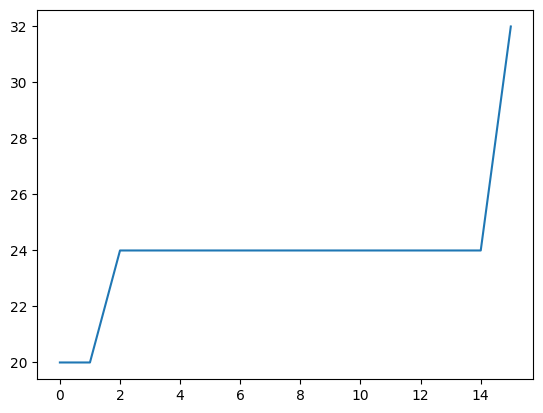

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.plot([i for i in range(len(best_scores))], best_scores)
plt.show()